# Tutorial of Image Segmentation

Pytorch 官网：<https://pytorch.org/>

# Modules

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Convolutional Layer

In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, out_flag = False):
        super().__init__()
        self.out_flag = out_flag
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv1(x)
        if self.out_flag:
            print('Hidden:',x.shape)
        out = self.conv2(x)
        return out

### Pytorch Doc:
![TorchConv1](./Figs/TorchConv1.png)
![TorchConv2](./Figs/TorchConv2.png)

In [3]:
module = DoubleConv(1, 64, out_flag = True)
print(module)
print('========================================================')
test = torch.ones(1, 1, 572, 572)
print('Input:', test.shape)
out = module(test)
print('Output:', out.shape)

DoubleConv(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)
Input: torch.Size([1, 1, 572, 572])
Hidden: torch.Size([1, 64, 570, 570])
Output: torch.Size([1, 64, 568, 568])


## Downsample Layer

In [4]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, out_flag = False):
        super().__init__()
        self.out_flag = out_flag
        self.maxpool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.maxpool(x)
        if self.out_flag:
            print('Hidden:',x.shape)
        return self.conv(x)

### Pytorch Doc:
![TorchPool1](./Figs/TorchPool1.png)
![TorchPool2](./Figs/TorchPool2.png)

In [5]:
module = Down(64, 128, out_flag = True)
print(module)
print('========================================================')
test = torch.ones(1, 64, 568, 568)
print('Input:', test.shape)
out = module(test)
print('Output:', out.shape)

Down(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv): DoubleConv(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
)
Input: torch.Size([1, 64, 568, 568])
Hidden: torch.Size([1, 64, 284, 284])
Output: torch.Size([1, 128, 280, 280])


## Upsample Layer

In [6]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, out_flag = False):
        super().__init__()
        
        self.out_flag = out_flag
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # Error?
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        
        if self.out_flag:
            print('Hidden: x1:', x1.shape, 'x2:', x2.shape, diffX, diffY)

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        if self.out_flag:
            print('Hidden:', x.shape)
        return self.conv(x)

In [7]:
module = Up(128, 64, bilinear = False, out_flag = True)
print(module)
print('========================================================')
test1 = torch.ones(1, 128, 276, 276)
test2 = torch.ones(1, 64, 568, 568)
print('Input:', test1.shape, test2.shape)
out = module(test1, test2)
print('Output:', out.shape)

Up(
  (up): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv): DoubleConv(
    (conv1): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
)
Input: torch.Size([1, 128, 276, 276]) torch.Size([1, 64, 568, 568])
Hidden: x1: torch.Size([1, 64, 552, 552]) x2: torch.Size([1, 64, 568, 568]) tensor([16]) tensor([16])
Hidden: torch.Size([1, 128, 568, 568])
Output: torch.Size([1, 64, 564, 564])


## Out Layer

In [8]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [9]:
module = OutConv(64, 2)
print(module)
print('========================================================')
test = torch.ones(1, 64, 388, 388)
print('Input:', test.shape)
out = module(test)
print('Output:', out.shape)

OutConv(
  (conv): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
)
Input: torch.Size([1, 64, 388, 388])
Output: torch.Size([1, 2, 388, 388])


# Model

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
net = UNet(1, 2, bilinear = False)
print(net)
print('==================================================')
test = torch.ones(4, 1, 572, 572)
print('Input:',test.shape)
out = net(test)
print('Output:',out.shape)

UNet(
  (inc): DoubleConv(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### UNet Scope
![UnetScope](./Figs/UnetScope.png)

In [12]:
import time

test = torch.ones(4, 1, 520, 520)
print('Input:',test.shape)
startt = time.time()
out = net(test)
endt = time.time()
print('Output:',out.shape)
print()
print('Forward takes time:', endt-startt, 's')

Input: torch.Size([4, 1, 520, 520])
Output: torch.Size([4, 2, 512, 512])

Forward takes time: 13.771862983703613 s


# Dataset

![CV2Install](./Figs/CV2Install.png)

In [13]:
import math
import torch
import cv2
import os
import glob
from torch.utils import data as Data
from torch.utils.data import Dataset
import random

In [14]:
class ISBI_Dataset(Dataset):
    def __init__(self, data_path):
        # 初始化函数，读取所有data_path下的图片
        self.data_path = data_path
        self.imgs_path = glob.glob(os.path.join(data_path, '*.png'))

    def augment(self, image, flipCode):
        # 使用cv2.flip进行数据增强，filpCode为1水平翻转，0垂直翻转，-1水平+垂直翻转
        flip = cv2.flip(image, flipCode)
        return flip
        
    def __getitem__(self, index):
        # 根据index读取图片
        image_path = self.imgs_path[index]
        # 根据image_path生成label_path
        label_path = image_path.replace('image', 'label')
        # 读取训练图片和标签图片
        image = cv2.imread(image_path)
        label = cv2.imread(label_path)
        # 将数据转为单通道的图片
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        image = image.reshape(1, image.shape[0], image.shape[1])
        label = label.reshape(1, label.shape[0], label.shape[1])
        # 处理标签，将像素值为255的改为1
        if label.max() > 1:
            label = label / 255
        # 图像标准化至[0，1]空间
        image = (image - image.min())/(image.max() - image.min())
        # 随机进行数据增强，为2时不做处理
        flipCode = random.choice([-1, 0, 1, 2])
        if flipCode != 2:
            image = self.augment(image, flipCode)
            label = self.augment(label, flipCode)
        return image, label

    def __len__(self):
        # 返回训练集大小
        return len(self.imgs_path)

In [15]:
BATCH_SIZE = 4

dataset = ISBI_Dataset(data_path = './data/train/image/')

train_loader = Data.DataLoader(
    dataset=dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)
total = math.ceil(len(dataset)/BATCH_SIZE)
print('Total Step:',total)
print()
for step, (batch, label) in enumerate(train_loader):
    print(step, batch.shape, label.shape)

Total Step: 8

0 torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
1 torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
2 torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
3 torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
4 torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
5 torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
6 torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
7 torch.Size([2, 1, 512, 512]) torch.Size([2, 1, 512, 512])


### Torchvision preprocess Doc:
![TorchPrep](./Figs/TorchPrep.png)

# Train

In [16]:
!nvidia-smi

Wed Dec  6 10:01:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0 Off |                  N/A |
| 37%   32C    P8     3W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [17]:
!gpustat

amax_242                       Wed Dec  6 10:01:03 2023  515.76
[0] NVIDIA GeForce RTX 2080 Ti | 32'C,   0 % |   245 / 11264 MB |
[1] NVIDIA GeForce GTX 1080 Ti | 23'C,   0 % |    87 / 11264 MB |
[2] NVIDIA GeForce RTX 2080 Ti | 29'C,   0 % |   245 / 11264 MB |
[3] NVIDIA GeForce RTX 2080 Ti | 28'C,   0 % |   245 / 11264 MB |
[4] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |    87 / 11264 MB |
[5] NVIDIA TITAN Xp            | 25'C,   0 % |    93 / 12288 MB |
[6] NVIDIA TITAN Xp            | 24'C,   0 % |    93 / 12288 MB |


In [18]:
torch.cuda.is_available()

True

In [19]:
import time
import torch.optim as optim

LR = 1e-4
BATCH_SIZE = 4

dataset = ISBI_Dataset(data_path = './data/train/image')

model = UNet(1, 2, bilinear = False).cuda()
model.train()  # batch_norm/drop_out

optimizer = optim.AdamW(model.parameters(), lr=LR)

print(model)
print('===============================================')

train_loader = Data.DataLoader(
    dataset=dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)
total = math.ceil(len(dataset)/BATCH_SIZE)
print('Total Step:',total)
print()
for step, (batch, label) in enumerate(train_loader):
    print(step, batch.shape, label.shape)
    break

x = F.pad(batch.float(), [4, 4, 4, 4]).cuda()
y = label.long().squeeze().cuda()

print('Input: x:',batch.shape, x.shape, '\n\ty:', label.shape, label.min(), label.max())
startt = time.time()
out = model(x)
endt = time.time()
print('Output:',out.shape)
print()
print('Forward takes time:', endt-startt, 's')

UNet(
  (inc): DoubleConv(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Loss Func

In [20]:
loss_fn = nn.CrossEntropyLoss()

print('out', out.shape, 'y',y.shape)

optimizer.zero_grad()
loss = loss_fn(out, y)
print('Loss:', loss)

out torch.Size([4, 2, 512, 512]) y torch.Size([4, 512, 512])
Loss: tensor(0.6735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


## Optimize

In [21]:
startt = time.time()

loss.backward()
optimizer.step()

endt = time.time()
print('Backward takes time:', endt -startt, 's')

Backward takes time: 0.20781850814819336 s


In [22]:
for i, (n, p) in enumerate(model.named_parameters()):
    if p.grad is None:
        print(i, n, 'grad is None')
    elif (p.grad == 0).all():
        print(i, n, 'grad lost')
    else:
        print(i, n, p.grad.mean())

0 inc.conv1.0.weight tensor(0.0032, device='cuda:0')
1 inc.conv1.0.bias tensor(3.1759e-09, device='cuda:0')
2 inc.conv1.1.weight tensor(1.4970e-08, device='cuda:0')
3 inc.conv1.1.bias tensor(-0.0002, device='cuda:0')
4 inc.conv2.0.weight tensor(0.0002, device='cuda:0')
5 inc.conv2.0.bias tensor(1.3048e-10, device='cuda:0')
6 inc.conv2.1.weight tensor(-3.1596e-05, device='cuda:0')
7 inc.conv2.1.bias tensor(-2.8665e-06, device='cuda:0')
8 down1.conv.conv1.0.weight tensor(-1.0205e-05, device='cuda:0')
9 down1.conv.conv1.0.bias tensor(6.6791e-12, device='cuda:0')
10 down1.conv.conv1.1.weight tensor(-1.3461e-10, device='cuda:0')
11 down1.conv.conv1.1.bias tensor(1.3774e-07, device='cuda:0')
12 down1.conv.conv2.0.weight tensor(-1.4085e-06, device='cuda:0')
13 down1.conv.conv2.0.bias tensor(-2.4517e-11, device='cuda:0')
14 down1.conv.conv2.1.weight tensor(-3.3582e-06, device='cuda:0')
15 down1.conv.conv2.1.bias tensor(-4.4887e-07, device='cuda:0')
16 down2.conv.conv1.0.weight tensor(-2.9813e-

### Few Concepts:
* Scheduler
* Warm up
* Early Stop (Overfitting)
* K fold cross validation

## Log

In [23]:
from tensorboardX import SummaryWriter

writer = SummaryWriter('./tensorboard/test_logger/')
for i in range(10):
    writer.add_scalar('Quadratic', i**2, global_step=i)
    writer.add_scalar('Exponential', 2**i, global_step=i)
writer.close()

In [24]:
!tensorboard --logdir './tensorboard/test_logger/' --host 192.168.0.242

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.11.2 at http://192.168.0.242:6006/ (Press CTRL+C to quit)
^C


In [25]:
!tensorboard --logdir './tensorboard/train_unet/' --host 192.168.0.242

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.11.2 at http://192.168.0.242:6006/ (Press CTRL+C to quit)
^C


# Inference

## Save & Load Parameters

In [26]:
torch.save(net.state_dict(), './net_params/test_save.pt')
print(os.listdir('./net_params/'))

['net_params.pt', 'net_params_best.pt', 'test_save.pt']


In [27]:
net.load_state_dict(torch.load('./net_params/test_save.pt'))

<All keys matched successfully>

## Test

In [28]:
from model import UNet

net = UNet(n_channels=1, n_classes=2, bilinear = False)
net.load_state_dict(torch.load('./net_params/net_params_best.pt')['state_dict'])
net.eval()
print(net)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down): ModuleList(
    (0): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
            (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

In [29]:
i = 3
BATCH_SIZE = 1

#dataset = ISBI_Dataset(data_path = './data/train/image/')
dataset = ISBI_Dataset(data_path = './data/test/')

test_loader = Data.DataLoader(
    dataset=dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False)
total = math.ceil(len(dataset)/BATCH_SIZE)
print('Total Step:',total)
print()

count = 0
for step, (batch, label) in enumerate(test_loader):
    print(step, batch.shape, label.shape)
    if count == i:
        break
    count+=1

print()

x = F.pad(batch.float(), [4, 4, 4, 4]).cuda()
y = (label>0.5).long().squeeze().cuda()
out = net(x.float().cpu())
print('pred:',out.shape,'label:',y.shape)

Total Step: 30

0 torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
1 torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
2 torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
3 torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])

pred: torch.Size([1, 2, 512, 512]) label: torch.Size([512, 512])


## Metrics

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

pred = F.softmax(out, dim = 1)[0].transpose(0,1).transpose(1,2).flatten(0,1).clone().detach_().cpu()
gt = label[0].transpose(0,1).transpose(1,2).flatten(0,1)

print('pred:',pred.shape, 'label:',gt.shape)
print()
print('Accuracy:', accuracy_score(gt.long(), pred.argmax(dim = -1)))
print('Precision:', precision_score(gt.long(), pred.argmax(dim = -1)))
print('Recall:', recall_score(gt.long(), pred.argmax(dim = -1)))
print('F1:', f1_score(gt.long(), pred.argmax(dim = -1)))

print('AUC ROC:', roc_auc_score(gt.long(), pred[:,1].double()))

pred: torch.Size([262144, 2]) label: torch.Size([262144, 1])

Accuracy: 0.41020965576171875
Precision: 0.00015520519420049924
Recall: 1.0
F1: 0.00031036221857259243
AUC ROC: 0.7594609180273666


$Dice(A,B)=2\frac{|A \cap B|}{|A|+|B|}$

In [31]:
def dice_score(pred, label):
    assert pred.shape == label.shape
    return 2*(pred*label).sum()/(pred.sum()+label.sum())

pred_mask = F.softmax(out, dim = 1)[0].transpose(0,1).transpose(1,2).clone().detach_().cpu()[:,:,1]
gt_mask = label[0].transpose(0,1).transpose(1,2).squeeze()
print('pred:',pred_mask.shape, 'label:',gt_mask.shape)
print()

print('Dice:', dice_score(pred_mask, gt_mask))

pred: torch.Size([512, 512]) label: torch.Size([512, 512])

Dice: tensor(0.6310, dtype=torch.float64)


$Jaccard(A,B)=\frac{|A \cap B|}{|A \cup B|}$

In [32]:
def iou_score(pred, label):
    assert pred.shape == label.shape
    return (pred*label).sum()/((pred + label).sum() - (pred*label).sum())

pred_mask = F.softmax(out, dim = 1)[0].transpose(0,1).transpose(1,2).clone().detach_().cpu()[:,:,1]
gt_mask = label[0].transpose(0,1).transpose(1,2).squeeze()
print('pred:',pred_mask.shape, 'label:',gt_mask.shape)
print()

print('IoU:', iou_score(pred_mask, gt_mask))

pred: torch.Size([512, 512]) label: torch.Size([512, 512])

IoU: tensor(0.4609, dtype=torch.float64)


## Visualize

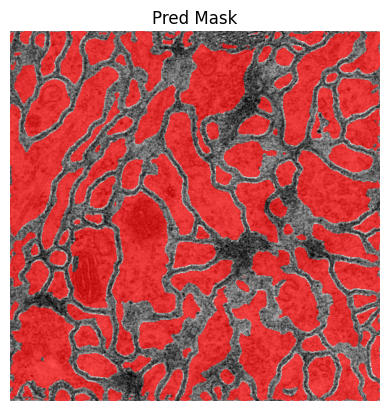

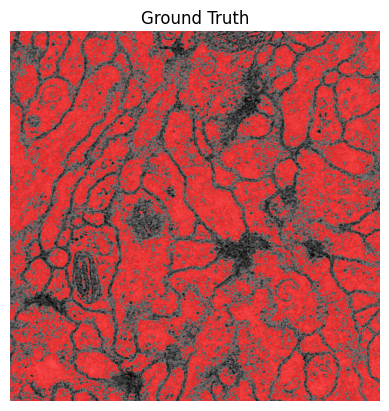

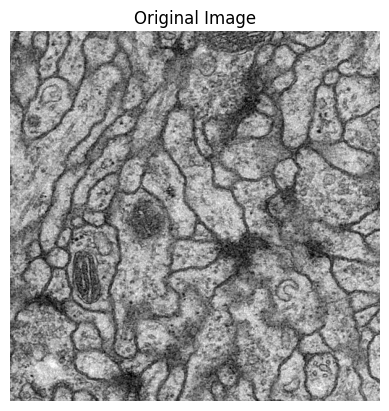

In [35]:
import matplotlib.pyplot as plt

factor = 0.7
color = torch.from_numpy(np.array([255, 0, 0]))

img       = (batch.squeeze().unsqueeze(dim = -1).expand([batch.shape[2], batch.shape[3], 3]).cpu()*255).int()
mask_pred = (F.softmax(out, dim = 1)[0, 1] > 0.5).unsqueeze(dim = -1).expand([y.shape[0], y.shape[1], 3]).cpu().bool()
mask_true = y.unsqueeze(dim = -1).expand([y.shape[0], y.shape[1], 3]).cpu().bool()

plt.imshow(img.numpy())
plt.title('Original Image')
plt.axis('off')
plt.show()

plt.imshow(torch.round(img * (~mask_pred) + (mask_pred * color)*factor + (mask_pred * img)*(1-factor)).int().numpy())
plt.title('Pred Mask')
plt.axis('off')
plt.show()

if 'test' not in dataset.data_path:
    plt.imshow(torch.round(img * (~mask_true) + (mask_true * color)*factor + (mask_true * img)*(1-factor)).int().numpy())
    plt.title('Ground Truth')
    plt.axis('off')
    plt.show()

## Some Materials

* Mofan Python 官网：<https://mofanpy.com/>
* 个人推荐使用VSCode作为你的编程工具 官网：<https://code.visualstudio.com/>

 <br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>

本教程用于由应豪超老师主讲的浙江大学公共卫生学院课程《AI医学影像处理基础与实践》，仅供参考

本教程参考Jack-Cherish老师Github项目Deep-Learning中的Pytorch-Seg部分，并按个人理解修正了部分问题

链接：<https://github.com/Jack-Cherish/Deep-Learning>

<br/><br/><br/><br/><br/>

制作人：徐宇扬
                                                                           
项目链接：<https://github.com/OwlCitizen/The-Basis-and-Practice-of-Medical-Image-Processing-based-on-Artificial-Intelligence-Tutorial>